# INF8953DE: Assignment 3 - Policy Gradient Methods
    
Due on : Nov 19, 10:00 pm 


# RL Assignment 03
Name : Vishal Ghorpade
---
Number at Poly:2175243
---
UdeM Matricule: 20170516
---

# Policy Gradient Methods

In this assignment, you will code RL agents that will learn a parameterized policy to solve the [CartPole](https://gym.openai.com/envs/CartPole-v1/) task. Simply put, the CartPole task is to balance a pole on a cart. Towards that, you will code and analyze different policy gradient methods that can maximize the objective of balancing the pole on cart without falling for maximum time. 

## Environment Details

For this assignment, we will use the [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/) environment provided in the [OpenAI-Gym](https://gym.openai.com/docs/). The following is a description of the task as given in the gym:

 **CartPole Task:** 
*A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.*
 
Detailed description and code can be found [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).




# Policy Gradient Skeleton Code

## Pseudocode
For this assignment you are asked to implement the policy gradient algorithms in the following pseudocode style. 

-------------------------------------------------------------------------------
**Input:** a differentiable policy network $\pi_\theta \in \mathcal{R}^d$ \\
**Algorithm parameters:** 


1.   $\alpha$: step size > 0
2.   n_iterations: number of gradient updates  > 0
3.   n_episodes: number of episodes per gradient update  > 0 

Initialize policy parameters 

loop for n_iterations: \\
  &emsp;&emsp;sample a dataset of episodes according to $\pi_\theta$ \\
  
  &emsp;&emsp;# compute policy gradient \\
  &emsp;&emsp;$\nabla_\theta J(\theta) = \sum_j \sum_t \psi_{jt} \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
  &emsp;&emsp; # where the first summation is over the episodes and the second summation is over the trajectory of the episode. \\
  
  &emsp;&emsp;# update policy parameters \\
  &emsp;&emsp;$\theta_i = \theta_i + \alpha \nabla_\theta J(\theta)$
  
------------------------------------------------------------------------------

Please note that this version of the algorithm is different from the one you will see in the textbook. Specifically, instead of computing the gradient for each episode, we collect a batch of episodes and then compute our gradient using this entire batch (or dataset).


## Installations and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run this cell

# install dependencies
!pip install torch torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
# Run this cell

# type hinting 
from typing import Sequence, Tuple, Dict, Any, Optional

import numpy as np

# torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

# env
import gym
from gym.wrappers import Monitor

# data manipulation, colab dispaly, and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

# misc util
import random, glob, base64, itertools
from pathlib import Path
from pprint import pprint

A util function to visualize the environment in colab:

In [ ]:
# Run this cell
def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start(); 

## Building the Policy Network

The following piece of code is a util to make dense nets with PyTorch.

In [ ]:
# Run this cell
class Model(nn.Module):
    def __init__(self, features: Sequence[int]):
        """Fully-connected Network

        Args:
            features: a list of ints like: [input_dim, 16, 16, output_dim]
        """
        super(Model, self).__init__()
        
        layers = []
        for i in range(len(features) - 1):
            layers.append(
                nn.Linear(
                    in_features=features[i],
                    out_features=features[i + 1],
                    )
            )
            if i != len(features) - 2:
                layers.append(nn.ReLU())
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, input):
        return self.net(input)

## Building the Base Agent Class

In [ ]:
# Run this cell
class BaseAgent(object):
    """ The base agent class function.
    """
    
    def __init__(self, config: Dict[str, Any]):
        """
        args:
            config: configuration dictionary
        """
        self.config = config

        # assert len(config['policy_layers']) > 0 # this won't allow linear models

        # environment
        self.env = gym.make(config['env_id'])
        self.gamma = config['gamma']

        # set seed
        np.random.seed(seed=config['seed'])
        self.env.seed(config['seed'])
        torch.manual_seed(config['seed'])

        # build policy model
        _policy_logits_model = Model(
            [self.env.observation_space.shape[0]] + 
            config['policy_layers'] + # note that these are only the intermediate layers
            [self.env.action_space.n],
        )
        # NOTE: by design, policy model should take *batches* of states as input.
        # self.policy_model spits out the probability of each action
        self.policy_model = nn.Sequential(
            _policy_logits_model, nn.Softmax(dim=1), 
        )
        self.policy_optimizer = torch.optim.Adam(
            self.policy_model.parameters(), 
            lr=config['policy_learning_rate'],
        )
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)

        if config['use_baseline']:
            self.value_model = Model(
              [self.env.observation_space.shape[0]] + 
              self.config['value_layers'] + [1],
            )
            self.value_optimizer = torch.optim.Adam(self.value_model.parameters(), lr=config['value_learning_rate'])
    
    def _make_returns(self, rewards: np.ndarray):
        """ Compute the cumulative discounted rewards at each time step

        args:
            rewards: an array of step rewards

        returns:
            returns: an array of discounted returns from that timestep onward
        """
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in reversed(range(len(rewards) - 1)):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        return returns
    
    # Method to implement
    def optimize_model(self, n_episodes: int) -> np.ndarray:
        """ Takes a gradient step on policy (and value) parameters using 
            `n_episodes` number of episodes. You'll need to implement
            this method for each part of this problem: namely, gather a 
            dataset of size `n_episodes`, approximate the gradient using 
            REINFORCE, and apply it to the model parameters. 

        args:
            n_episodes: number of trajectories in dataset

        returns:
            returns: the total discounted reward of each trajectory/episode.
        """
        
        raise NotImplementedError
    
    def train(self, n_episodes: int, n_iterations: int, plot: bool = True) -> Sequence[np.ndarray]:
        """ Train.
        args:
            n_episodes: number of episodes for each gradient step
            n_iterations: determine training duration
        """
        
        rewards = []
        for it in range(n_iterations):
            rewards.append(self.optimize_model(n_episodes))
            print(f'Iteration {it + 1}/{n_iterations}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')

        if plot:
            self.plot_rewards(rewards)

        return(rewards)
        
    @staticmethod
    def plot_rewards(rewards: Sequence[np.ndarray], ax: Optional[Any] = None):
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        if ax is None:
            sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        else:
            sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd', ax=ax);
        
    def evaluate(self):
        """ Evaluate and visualize a single episode.
        """
        
        observation = self.monitor_env.reset()
        observation = torch.tensor(observation, dtype=torch.float)[None, :]
        reward_episode = 0
        done = False
            
        while not done:
            probs = self.policy_model.forward(observation)
            action = torch.multinomial(probs, 1)[0] # draw samples from dist
            observation, reward, done, info = self.monitor_env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)[None, :]
            reward_episode += reward
        # print("here")
        self.monitor_env.close()
        print(f'Reward: {reward_episode}')
        # show_video("./gym-results")
        

#Qn 1. REINFORCE ALGORITHM [65 Marks]

## Qn 1.1 REINFORCE with episodal returns [25 Marks]


### Qn1.1.a: Implement a `REINFORCEv1` agent [20 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t G_0^j \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_0^j=\sum_{k = 0}^{\infty} \gamma^{k} R_{k+1}^j$ is the discounted return for the start state, $s_0^j$ for the episode $j$. . \\

Note that this is different from the REINFORCE algorithm we have seen in the class since we are using only the episodal return in the policy gradient computation for all state updates instead of using the corresponding return from individual states. We will implement the in-class version of REINFORCE in the next part.

You will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.


In [ ]:
# Insert your code and run this cell
class REINFORCEv1Agent(BaseAgent):
    """ REINFORCE agent with total trajectory reward.
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value

            HINTS:
                
                * Note that policy network model (self.policy_model) outputs the 
                probability of taking each discrete action. Hence, you need
                to sample from this distribution. Take a look at `self.evaluate()` 
                method in the `BaseAgent` class.

                * Keep in mind that policy network takes batches of states as 
                input, as opposed to a single state vector. This is by design,
                and good/common practice, however, you need to keep an eye on 
                the input/output dimensions.

        """

        # ======================================================================

        # INSERT YOUR CODE HERE !
        batch_size = 16
        log_prob = torch.zeros(n_episodes)
        total_rewards = np.zeros(n_episodes)
        j = 0
        for i in range(n_episodes):
            done = False
            gamma_c = self.gamma
            logprobs = []
            state = self.monitor_env.reset()
            state = torch.tensor(state, dtype=torch.float)[None, :]
            rewards_episode = []
            while not done:
                probs = self.policy_model.forward(state)
                action = torch.multinomial(probs, 1)[0]
                logprobs.append(torch.log(probs)[0,action])
                state, reward, done,_ = self.env.step(int(action))
                state = torch.tensor(state, dtype=torch.float)[None, :]
                G_t = gamma_c * reward
                gamma_c *= self.gamma
                rewards_episode.append(G_t)
            total_rewards[i] = np.sum(rewards_episode)
            log_prob[i]= torch.sum(np.sum(rewards_episode) * torch.cat(logprobs))
            j +=1
            # if j%batch_size==0:
                # loss = -weighted_logprob.mean()
                # self.policy_optimizer.zero_grad()
                # loss.backward()
                # self.policy_optimizer.step()
                # j=0
                # weighted_logprob = torch.zeros(batch_size)
            
        loss = -torch.mean(log_prob)
        self.policy_optimizer.zero_grad()
        loss.backward()
        self.policy_optimizer.step()
        # total_rewards = all_rewards#np.asarray(all_rewards)
        return total_rewards

Iteration 1/100: rewards 18.28 +/- 8.44
Iteration 2/100: rewards 16.74 +/- 4.84
Iteration 3/100: rewards 21.42 +/- 11.21
Iteration 4/100: rewards 20.02 +/- 11.18
Iteration 5/100: rewards 20.84 +/- 13.11
Iteration 6/100: rewards 22.5 +/- 10.26
Iteration 7/100: rewards 22.4 +/- 11.46
Iteration 8/100: rewards 24.98 +/- 12.99
Iteration 9/100: rewards 21.3 +/- 8.47
Iteration 10/100: rewards 25.46 +/- 15.24
Iteration 11/100: rewards 25.3 +/- 10.97
Iteration 12/100: rewards 26.72 +/- 16.78
Iteration 13/100: rewards 28.94 +/- 15.54
Iteration 14/100: rewards 24.36 +/- 10.87
Iteration 15/100: rewards 28.08 +/- 16.78
Iteration 16/100: rewards 30.5 +/- 16.24
Iteration 17/100: rewards 29.8 +/- 17.04
Iteration 18/100: rewards 35.96 +/- 20.14
Iteration 19/100: rewards 35.06 +/- 19.67
Iteration 20/100: rewards 36.44 +/- 20.72
Iteration 21/100: rewards 34.64 +/- 19.68
Iteration 22/100: rewards 34.02 +/- 16.76
Iteration 23/100: rewards 38.34 +/- 20.77
Iteration 24/100: rewards 41.92 +/- 23.4
Iteration 2

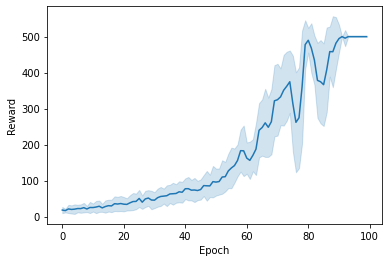

In [ ]:
# You will be graded on this output this cell, so kindly run it

# This is an example configuration that is tuned for the above question. 
# keep the same config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': False,
}
agent = REINFORCEv1Agent(config)
REINFORCEv1_rewards = agent.train(n_episodes=50, n_iterations=100)

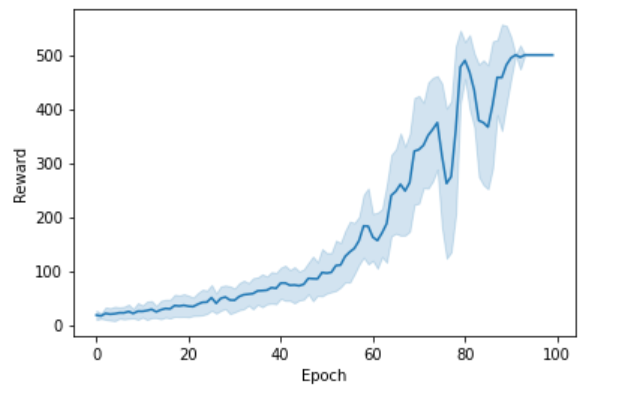


**Plot for REINFORCEv1**


In [ ]:
# You will be graded on this output this cell, so kindly run it
agent.evaluate()

Reward: 500.0


**Note: Video output was cleared as it was colapsing the colab due to render and playing of the video. Also for pdf generation it was causing an issue.**

### Qn:1.1.b:Why can we allow ourselves to use $\gamma = 1.0$ here? [3 Marks]


Discount factor gamma's role is to accommodate theoretical convergence of the reward sequence for infinite-horizon episodes. Practically a discount factor $\gamma <1$ can improve convergence and reduce variance in the policy gradient updates. But with simple problems with short trajectories it is often unneeded. In the above setup we can see that we are considering reward from the start state.

### Qn 1.1.c: If you have implemented everything correctly, you will notice that training iterations tend to take a bit longer towards the end compared to early stages of the training, why? [2 Marks]


Toward the end iterations the training iterations are longer and the probable reason for this would be that the rewards/ returns are larger at the end iterations which in turn increase the computation and backpropagation time leading a bit longer training time for the iterations.

## Qn 1.2 REINFORCE with returns [15 Marks]




###Qn 1.2.a Implement `REINFORCEv2` agent as described below. [10 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t G_t^j \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_t^j=\sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1}^j$ is the discounted return computed starting from the current state, $s_t^j$ for the episode $j$. \\

Let's call this agent REINFORCEv2.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [ ]:
# Insert your code and run this cell
class REINFORCEv2Agent(BaseAgent):
    """ Not Vanilla REINFORCE Agent:
        *Not* vanilla, in the sense that we are now going to weight the action 
        logprobs, proportionate to the onward return as opposed to the total 
        episodic return. 
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value

            HINTS:
                Hints from the previous section hold here except/plus that:
                
                * You probably DO need to call the `BaseAgent._make_returns`
                method in this part. 

                * You basically need to copy a lot of stuff you've done in the 
                previous part, but have to scale the logprobs with different 
                values.
        """
        # ======================================================================

        # YOUR CODE HERE !

        # ======================================================================
        batch_size = 16
        log_prob = torch.zeros(n_episodes)#batch_size)
        total_rewards = np.zeros(n_episodes)
        j = 0
        for i in range(n_episodes):
            done = False
            logprobs = []
            gamma_c = self.gamma
            state = self.monitor_env.reset()
            state = torch.tensor(state, dtype=torch.float)[None, :]
            rewards_episode = []
            while not done:
                probs = self.policy_model.forward(state)
                action = torch.multinomial(probs, 1)[0]
                logprobs.append(torch.log(probs)[0,action])
                state, reward, done, info = self.env.step(int(action))
                state = torch.tensor(state, dtype=torch.float)[None, :]
                rewards_episode.append(gamma_c * reward)
                gamma_c *= self.gamma
            total_rewards[i] = np.sum(rewards_episode)
            log_prob[i]= torch.sum(torch.FloatTensor(self._make_returns(rewards_episode)) * torch.cat(logprobs))
            j +=1
            # if j%batch_size==0:
            #     loss = -weighted_logprob.mean()
            #     self.policy_optimizer.zero_grad()
            #     loss.backward()
            #     self.policy_optimizer.step()
            #     j=0
            #     weighted_logprob = torch.zeros(batch_size)
            
        loss = -torch.mean(log_prob)
        self.policy_optimizer.zero_grad()
        loss.backward()
        self.policy_optimizer.step()
        # total_rewards = all_rewards#np.asarray(all_rewards)
        return total_rewards

Iteration 1/100: rewards 18.28 +/- 8.44
Iteration 2/100: rewards 16.74 +/- 4.84
Iteration 3/100: rewards 20.24 +/- 8.6
Iteration 4/100: rewards 21.66 +/- 9.97
Iteration 5/100: rewards 24.42 +/- 13.08
Iteration 6/100: rewards 24.42 +/- 14.64
Iteration 7/100: rewards 22.14 +/- 9.41
Iteration 8/100: rewards 24.78 +/- 12.52
Iteration 9/100: rewards 27.2 +/- 19.1
Iteration 10/100: rewards 29.32 +/- 15.98
Iteration 11/100: rewards 32.84 +/- 12.01
Iteration 12/100: rewards 33.02 +/- 15.31
Iteration 13/100: rewards 30.5 +/- 19.73
Iteration 14/100: rewards 36.62 +/- 17.06
Iteration 15/100: rewards 46.4 +/- 27.78
Iteration 16/100: rewards 43.14 +/- 22.45
Iteration 17/100: rewards 37.94 +/- 17.64
Iteration 18/100: rewards 37.04 +/- 20.1
Iteration 19/100: rewards 48.48 +/- 20.98
Iteration 20/100: rewards 46.66 +/- 20.99
Iteration 21/100: rewards 51.28 +/- 20.31
Iteration 22/100: rewards 53.82 +/- 26.35
Iteration 23/100: rewards 55.44 +/- 22.31
Iteration 24/100: rewards 56.58 +/- 18.84
Iteration 25

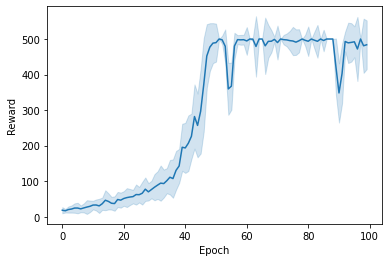

In [ ]:
# You will be graded on this output this cell, so kindly run it
# keep the same config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': False,
}
agent = REINFORCEv2Agent(config)
REINFORCEv2_rewards = agent.train(n_episodes=50, n_iterations=100)

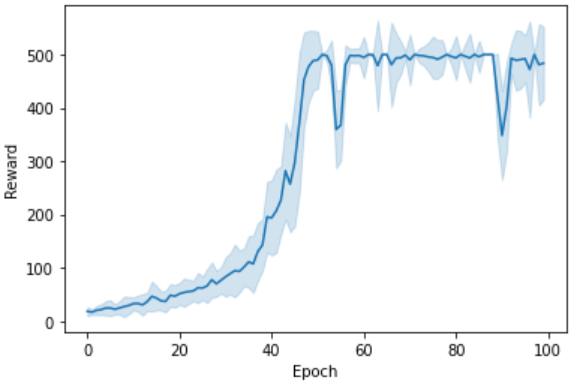

**Plot of REINFORCEv2**

In [ ]:
# You will be graded on this output this cell, so kindly run it
agent.evaluate()

Reward: 500.0


**Note: Video output was cleared as it was colapsing the colab due to render and playing of the video. Also for pdf generation it was causing an issue.**

### Qn 1.2.b: Plot and compare the performance of the `REINFORCEv1` and `REINFORCEv2` agents for $\gamma=1$. Report your observations and provide explanations for the same. [5 Marks]


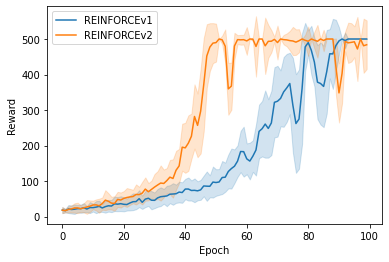

In [ ]:
# You will be graded on this output this cell, so kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv1_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2_rewards, ax)
plt.rcParams['figure.figsize'] = [20, 20]
plt.legend(labels=['REINFORCEv1', 'REINFORCEv2'])

From the plots we can see that the REINFORCE with a modified returns calculation learns faster when compared to the vanilla version of REINFORCE. The probable reason for the difference is that the returns for the REINFORCEv1 were computed from the start state where as for the REINFORCEv2 from the current state of the environment. Due to this we see that REINFORCEv2 converges faster than REINFORCEv1.

##Qn 1.3 REINFORCE WITH baseline 25 Marks]

### Qn 1.3.a Implement 'REINFORCEv2+B' agent as described below [15 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t (G_t^j - B(s_t^j)) \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_t^j=\sum_{k=0}^{\infty} \gamma^{k} r_{t+k+1}^j$ is the discounted return computed starting from the current state, $s_t^j$ for the episode $j$. \\

Herein implement the baseline to be an estimator of the state-value function of the state at $t$, $B(s_t)=V(s_t)$. Towards that implement a value network with parameters, $w$ to estimate the value of a state,i.e $B(s_t, w) = V(s_t)$. 

Let's call this agent REINFORCEv2+B.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [ ]:
# Insert your code and run this cell
class REINFORCEv2PlusBaselineAgent(BaseAgent):
    """ Baseline Agent: 
        Here we try to reduce the variance by introducing a baseline, which is 
        the value function in this case.
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value

            In addition here, you will have to compute the loss of the value function and 
            call auto-diff on this loss to updae the parameters of the value network.

            Here you have access to and need to make use of `self.value_model`
            and `self.value_optimizer`, and have to form a loss for updating the
            value function. 

            HINT:
                * You need to use torch's `.detach()` to prevent re-flowing 
                the gradients.
        """
        # ======================================================================

          # YOUR CODE HERE !

        # ======================================================================
        log_probs = torch.zeros(n_episodes)#[]#torch.empty(size=(0,), dtype=torch.float)# []#torch.zeros(n_episodes)
        total_rewards = np.zeros(n_episodes)
        batch_size =16
        value_s = torch.zeros(n_episodes)
        for i in range(n_episodes):
            done = False
            state = self.monitor_env.reset()
            state = torch.tensor(state, dtype=torch.float)[None, :]
            rewards = []
            l_p_epi = []
            discount_factor = self.gamma
            values = []
            while not done:
                probs = self.policy_model.forward(state)
                action = torch.multinomial(probs, 1)[0]
                l_p_epi.append(torch.log(probs)[0,action])
                state, reward, done, info = self.env.step(int(action))
                state = torch.tensor(state, dtype=torch.float)[None, :]
                rewards.append(reward)
                values.append(self.value_model.forward(state))
            G_t = self._make_returns(np.asarray(rewards))
            total_rewards[i] = np.sum(rewards)
            V = torch.cat(values)
            delta = torch.FloatTensor(G_t)-V#torch.FloatTensor(G_t) - V
            log_pr = torch.sum(delta * torch.cat(l_p_epi))
            # log_probs.append(log_pr)# = torch.cat((log_probs,log_pr),dim=0)
            # log_probs = torch.cat((torch.tensor(G_t).float() * torch.cat(l_p_epi).sum()),log_probs)
            log_probs[i] = log_pr
            value_s[i] = torch.sum(delta*V) #replace this mean-squre error
        loss = -torch.mean(torch.FloatTensor(log_probs))#log_probs))#torch.FloatTensor(log_probs)#.mean()
        value_loss = torch.mean(value_s) #torch.autograd.Variable(-torch.mean(value_s).detach())
        # print(value_loss)
        self.policy_optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.policy_optimizer.step()
            # additionally we update the value network parameters
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
            # log_probs = []
        # self.policy_optimizer.zero_grad()
        # policy_loss.backward()
        # self.policy_optimizer.step()

        # # additionally we update the value network parameters
        # self.value_optimizer.zero_grad()
        # value_loss.backward()
        # self.value_optimizer.step()
        return total_rewards
   

Iteration 1/100: rewards 18.7 +/- 9.48
Iteration 2/100: rewards 22.26 +/- 10.58
Iteration 3/100: rewards 21.94 +/- 10.2
Iteration 4/100: rewards 23.5 +/- 13.83
Iteration 5/100: rewards 25.84 +/- 12.42
Iteration 6/100: rewards 30.22 +/- 16.99
Iteration 7/100: rewards 24.22 +/- 12.95
Iteration 8/100: rewards 25.32 +/- 14.92
Iteration 9/100: rewards 30.02 +/- 21.46
Iteration 10/100: rewards 31.12 +/- 16.91
Iteration 11/100: rewards 30.86 +/- 17.38
Iteration 12/100: rewards 31.28 +/- 15.08
Iteration 13/100: rewards 29.96 +/- 16.27
Iteration 14/100: rewards 37.14 +/- 20.49
Iteration 15/100: rewards 38.72 +/- 18.84
Iteration 16/100: rewards 38.9 +/- 18.25
Iteration 17/100: rewards 37.5 +/- 18.28
Iteration 18/100: rewards 36.3 +/- 18.79
Iteration 19/100: rewards 39.7 +/- 18.03
Iteration 20/100: rewards 50.22 +/- 23.54
Iteration 21/100: rewards 49.3 +/- 32.26
Iteration 22/100: rewards 44.46 +/- 21.28
Iteration 23/100: rewards 54.88 +/- 23.9
Iteration 24/100: rewards 56.52 +/- 25.03
Iteration 2

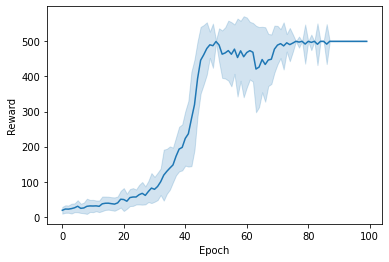

In [ ]:
# You will be graded on this output this cell, so kindly run it.
# keep the config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
}
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards = agent.train(n_episodes=50, n_iterations=100)

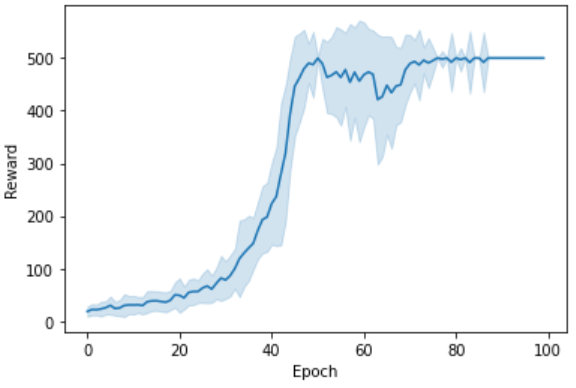

Above is the plot for base config

In [ ]:
# You will be graded on this output this cell, so kindly run this cell.
agent.evaluate()

Reward: 500.0


**Note: Video output was cleared as it was colapsing the colab due to render and playing of the video. Also for pdf generation it was causing an issue.**

### Qn 1.3.b : Does introducing baselines have a meaning beyond variance reduction? [5 Marks ]


By introducing baseline we reduce the variance of the algorithm by a good factor but apart from reducing variance using baseline also assissts in learning faster compared to the non-baseline versions of REINFORCE to converge faster.
 Using a baseline gives us as an estimate of how much better we did after time step t than is expected by the baseline. We also see that using baseline doesn’t add bias to the system and this can be proven mathematically as well.

### Qn 1.3.c Plot and compare `REINFORCEv2+B` for  $\gamma \in \{0.95, 0.975, 0.99, 0.995, 1\}$. [ 5 Marks]
Report your observations and explain the same.

In [ ]:
# Insert your code here and run this cell
gammas = [0.95,0.975,0.99,0.995,1]
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.95,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
    }
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards_095 = agent.train(n_episodes=50, n_iterations=100,plot=False)

In [ ]:
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.975,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
    }
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards_0975 = agent.train(n_episodes=50, n_iterations=100,plot=False)

In [ ]:
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.99,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
    }
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards_099 = agent.train(n_episodes=50, n_iterations=100,plot=False)

In [ ]:
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.995,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
    }
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards_0995 = agent.train(n_episodes=50, n_iterations=100,plot=False)

In [ ]:
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
    }
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards_1 = agent.train(n_episodes=50, n_iterations=100,plot=False)

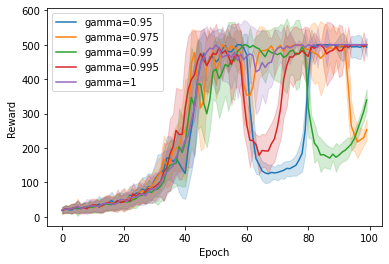

In [ ]:
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards_095, ax)
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards_0975, ax)
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards_099, ax)
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards_0995, ax)
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards_1, ax)
plt.rcParams['figure.figsize'] = [10, 10]
plt.legend(labels=[  'gamma=0.95','gamma=0.975' ,'gamma=0.99','gamma=0.995', 'gamma=1'])
plt.show()

From the plots we can see that the as we reduce gamma the reward is quite unstable and varies more often. From the plot we can see that the convergence rate is impacted by gamma and gamma values which are closer to 1 tend to converge faster.

#Qn 2. ACTOR CRITIC [35 Marks]


### Qn 3.1 Implement a one-step Actor-Critic agent below [15 Marks]. 

Implement an actor critic agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t (G_{t:t+1}^j - V(s_t^j)) \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_{t:t+1}^j= R_t + \gamma V(s_{t+1}^j)$ is the truncated one-step return computed starting from the current state, $s_t^j$ for the episode $j$. \\


Implement the critic network to be an estimator for state-value function.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [ ]:
class ActorCriticAgent(BaseAgent):
    """ A2C Agent: Actor-Critic
        Here we try to FURTHER reduce the variance via bootstrapping.
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value
            In addition implement the critic network
            HINT:
                * If you've made it this far you don't need another hint!
        """
        # ======================================================================

          # YOUR CODE HERE !
        # ======================================================================
        logprob = torch.zeros(n_episodes)
        total_rewards = np.zeros(n_episodes)
        value_s = torch.zeros(n_episodes) 
        for i in range(n_episodes):
            done = False
            log_probs_steps = []
            curr_states_vals = []            
            state = self.env.reset()
            state = torch.tensor(state, dtype=torch.float)[None, :]
            rewards = []
            Gt_t = []
            while not done:
                probs = self.policy_model.forward(state)
                action = torch.multinomial(probs, 1)[0]
                curr_states_vals.append(self.value_model.forward(state))
                log_probs_steps.append(torch.log(probs)[0,action])
                state, reward, done, info = self.env.step(int(action))
                state = torch.tensor(state, dtype=torch.float)[None, :]
                next_state_val = self.value_model.forward(state)
                rewards.append(reward)
                if len(rewards) < 500 and done:
                    Gt_t.append(reward)
                else:
                    Gt_t.append(reward + self.gamma * next_state_val)
            total_rewards[i] = np.sum(rewards_episode)
            curr_states_vals = torch.cat(curr_states_vals)
            curr_states_vals = torch.squeeze(curr_states_vals)
            Gt_target = torch.FloatTensor(Gt_t)
            TD_err =  Gt_target - curr_states_vals
            # print(TD_err.shape,(TD_err.detach() * torch.cat(log_probs_Steps)).shape)
            value_loss = TD_err.pow(2).mean()#F.mse_loss(Gt_target.detach(), curr_states_vals)
            # value_s[i] = F.mse_loss(Gt_target.detach(), curr_states_vals)
            logprob[i]= torch.sum(TD_err.detach() * torch.squeeze(torch.cat(log_probs_steps)))
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()
        policy_loss =  -torch.mean(logprob)
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        # self.value_optimizer.zero_grad()
        # value_loss.backward()
        # self.value_optimizer.step()    
        return total_rewards

Iteration 1/500: rewards 19.0 +/- 7.26
Iteration 2/500: rewards 18.59 +/- 9.64
Iteration 3/500: rewards 17.69 +/- 8.52
Iteration 4/500: rewards 20.94 +/- 6.98
Iteration 5/500: rewards 18.97 +/- 11.74
Iteration 6/500: rewards 18.41 +/- 9.07
Iteration 7/500: rewards 19.88 +/- 7.59
Iteration 8/500: rewards 18.81 +/- 8.39
Iteration 9/500: rewards 24.88 +/- 13.86
Iteration 10/500: rewards 22.0 +/- 10.93
Iteration 11/500: rewards 22.41 +/- 11.39
Iteration 12/500: rewards 18.62 +/- 6.64
Iteration 13/500: rewards 19.75 +/- 11.44
Iteration 14/500: rewards 20.38 +/- 11.38
Iteration 15/500: rewards 20.09 +/- 12.86
Iteration 16/500: rewards 20.62 +/- 7.74
Iteration 17/500: rewards 16.81 +/- 6.08
Iteration 18/500: rewards 19.66 +/- 9.52
Iteration 19/500: rewards 20.31 +/- 10.68
Iteration 20/500: rewards 17.31 +/- 6.37
Iteration 21/500: rewards 19.72 +/- 8.35
Iteration 22/500: rewards 20.22 +/- 9.21
Iteration 23/500: rewards 20.06 +/- 8.22
Iteration 24/500: rewards 19.28 +/- 9.94
Iteration 25/500: r

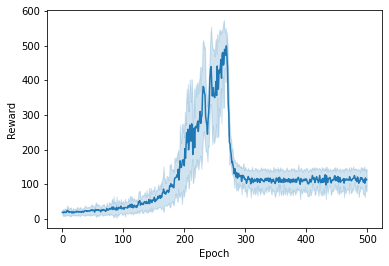

In [ ]:
# You will be graded on this output of this cell; so kindly run it
# Keep this config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-3,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 1e-2,
}
agent = ActorCriticAgent(config)
ActorCritic_rewards_v1 = agent.train(n_episodes=32, n_iterations=500)

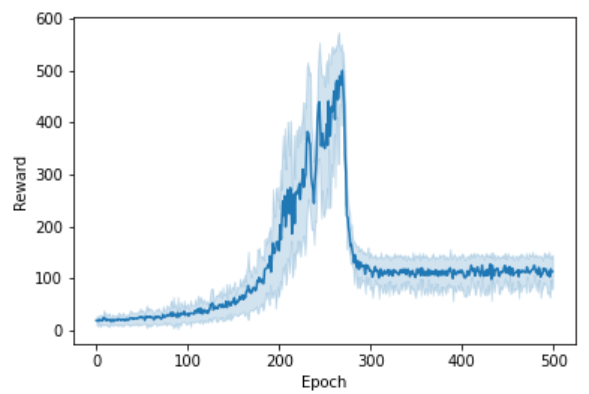

Plot for Actor-Critic with initial configurations

In [ ]:
# You will be graded on this output of this cell; so kindly run it 
agent.evaluate()

Reward: 392.0


### Qn 3.2: Eventhough the previous `REINFORCEv2+B` agent used a value estimator network similar to that of the Actor-Critic agent why is not called an Actor-Critic method ? [ 3 Marks]

 In actor-critic we bootstrap the values whereas in REINFORCE we are using the computed G.
In REINFORCE with baseline, the learned state-value function estimates the value of the only the first state of each state transition. This estimate sets a baseline for the subsequent return, but is made prior to the transition’s action and thus cannot be used to assess that action.

In actor-critic the state-value function is applied also to the second state of the transition. The estimated value of the second state, when discounted and added to the reward, constitutes the one-step return, Gt:t+1, which is a useful estimate of the actual return and thus is a way of assessing the action. 

Although REINFORCE-with-baseline method learns both a policy and a state-value function, we do not consider it to be an actor–critic method because its state-value function is used only as a baseline, not as a critic. That is, it is not used for bootstrapping (updating the value estimate for a state from the estimated values of subsequent states), but only as a baseline for the state whose estimate is being updated.


### Qn 3.3: How does the Actor-Critic algorithm reduces variance? What about bias? We are using one-step rewards here, is there a way we can strike a balance between variance and bias? [5 Marks]

Actor-critic return estimate is biased because V^πϕ(s,t+1) term is biased. It is biased because it is an approximation of the expected return at state (s,t+1). This term is represented by an approximator, for example a neural network or a linear regression model. That approximator will usually be randomly initialized so it will not give a true estimation of the return, it will be biased towards some random value that was initialized with. 

A balance can be struck using n-step Actor-critic instead on 1-step actor critic.All n-step returns can be considered approximations of the full return, truncated after n steps and then corrected for the remaining steps by $V_{t+n−1}$.
Bootstrapping in RL is when the learned estimate v^ from a successor state S′ is used to construct the update for a preceding state S


### Qn 3.4: Challenge! Can you tweak the hyperparameters of Actor-Critic to achieve better performance? Compare your results againts what you already have in section 3.1, in a single plot. [ 5 Marks]

Tune $\gamma$ within the same range as in Qn. 1.3.c and tune the hypereparameters of the value networks.

Iteration 1/750: rewards 19.06 +/- 9.1
Iteration 2/750: rewards 17.46 +/- 7.67
Iteration 3/750: rewards 20.04 +/- 7.2
Iteration 4/750: rewards 18.62 +/- 11.41
Iteration 5/750: rewards 17.66 +/- 6.57
Iteration 6/750: rewards 20.84 +/- 10.08
Iteration 7/750: rewards 19.96 +/- 8.88
Iteration 8/750: rewards 19.52 +/- 9.27
Iteration 9/750: rewards 17.08 +/- 8.19
Iteration 10/750: rewards 18.68 +/- 8.49
Iteration 11/750: rewards 17.3 +/- 6.81
Iteration 12/750: rewards 18.1 +/- 6.91
Iteration 13/750: rewards 19.3 +/- 8.76
Iteration 14/750: rewards 18.32 +/- 9.73
Iteration 15/750: rewards 19.12 +/- 10.32
Iteration 16/750: rewards 19.98 +/- 9.28
Iteration 17/750: rewards 17.26 +/- 7.69
Iteration 18/750: rewards 16.88 +/- 7.6
Iteration 19/750: rewards 21.52 +/- 11.65
Iteration 20/750: rewards 18.82 +/- 7.36
Iteration 21/750: rewards 20.74 +/- 10.73
Iteration 22/750: rewards 18.4 +/- 8.56
Iteration 23/750: rewards 19.6 +/- 8.91
Iteration 24/750: rewards 19.34 +/- 9.02
Iteration 25/750: rewards 20

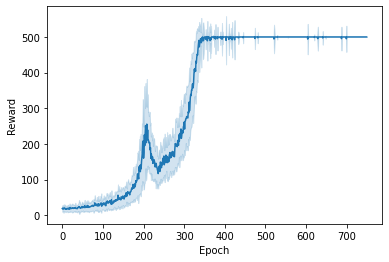

In [ ]:
# You will be graded on this output of this cell; so kindly run it
# Keep this config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.99,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-3,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 1e-3,
}
agent = ActorCriticAgent(config)
ActorCritic_rewards_099_2_Vo = agent.train(n_episodes=50, n_iterations=750)

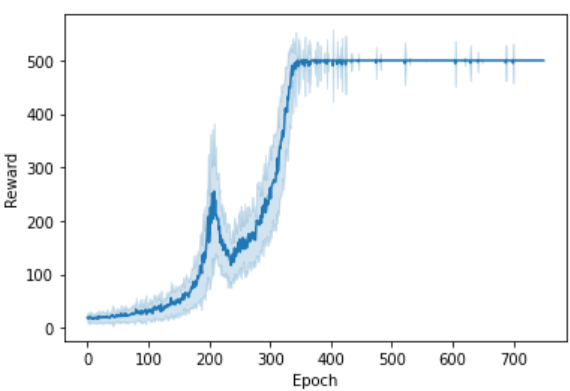

Plot for the above config

In [ ]:
# Insert your code here to search for best hyper-parameters
# Insert your code here to search for best hyper-parameters# You will be graded on this output of this cell; so kindly run it
# Keep this config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.99,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-3,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 1e-2,
}
agent = ActorCriticAgent(config)
ActorCritic_rewards_099 = agent.train(n_episodes=50, n_iterations=750)

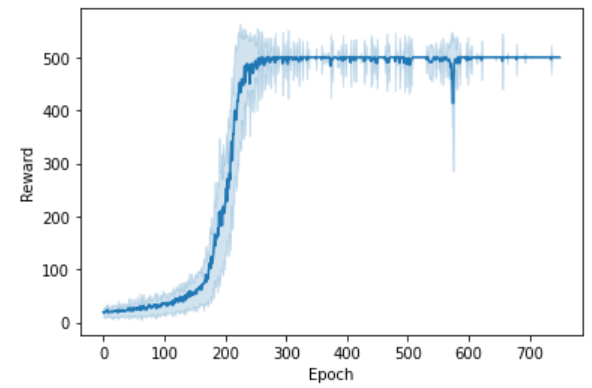

Plot for above config

Iteration 1/500: rewards 19.0 +/- 7.26
Iteration 2/500: rewards 18.59 +/- 9.64
Iteration 3/500: rewards 17.69 +/- 8.52
Iteration 4/500: rewards 20.94 +/- 6.98
Iteration 5/500: rewards 18.97 +/- 11.74
Iteration 6/500: rewards 18.41 +/- 9.07
Iteration 7/500: rewards 19.88 +/- 7.59
Iteration 8/500: rewards 18.81 +/- 8.39
Iteration 9/500: rewards 24.88 +/- 13.86
Iteration 10/500: rewards 22.0 +/- 10.93
Iteration 11/500: rewards 22.41 +/- 11.39
Iteration 12/500: rewards 18.62 +/- 6.64
Iteration 13/500: rewards 19.75 +/- 11.44
Iteration 14/500: rewards 20.38 +/- 11.38
Iteration 15/500: rewards 20.09 +/- 12.86
Iteration 16/500: rewards 20.62 +/- 7.74
Iteration 17/500: rewards 16.81 +/- 6.08
Iteration 18/500: rewards 19.66 +/- 9.52
Iteration 19/500: rewards 20.31 +/- 10.68
Iteration 20/500: rewards 17.31 +/- 6.37
Iteration 21/500: rewards 19.72 +/- 8.35
Iteration 22/500: rewards 20.22 +/- 9.21
Iteration 23/500: rewards 20.06 +/- 8.22
Iteration 24/500: rewards 19.28 +/- 9.94
Iteration 25/500: r

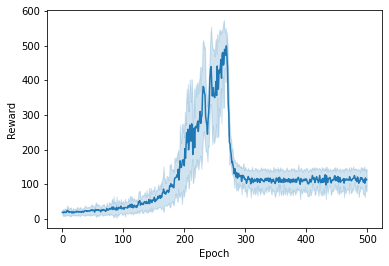

In [ ]:
# You will be graded on this output of this cell; so kindly run it
# Keep this config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-3,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 1e-2,
}
agent = ActorCriticAgent(config)
ActorCritic_rewards = agent.train(n_episodes=32, n_iterations=500)

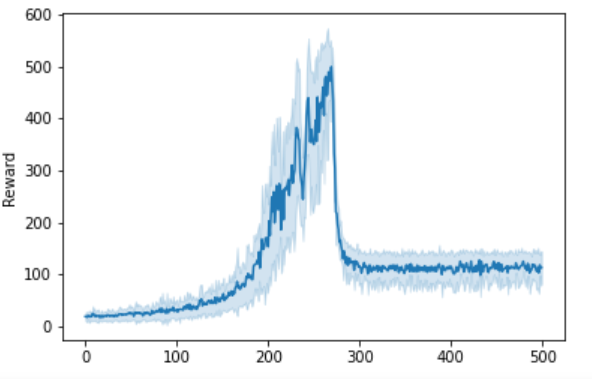

Above is plot for the base config

Choosing the optimal config of hyperparams based on the three experiments.

Iteration 1/500: rewards 18.26 +/- 8.45
Iteration 2/500: rewards 19.42 +/- 9.88
Iteration 3/500: rewards 20.69 +/- 9.56
Iteration 4/500: rewards 21.46 +/- 11.31
Iteration 5/500: rewards 17.83 +/- 7.36
Iteration 6/500: rewards 20.12 +/- 10.88
Iteration 7/500: rewards 19.69 +/- 8.37
Iteration 8/500: rewards 18.12 +/- 7.5
Iteration 9/500: rewards 19.95 +/- 8.93
Iteration 10/500: rewards 21.27 +/- 12.14
Iteration 11/500: rewards 20.23 +/- 10.16
Iteration 12/500: rewards 19.98 +/- 11.07
Iteration 13/500: rewards 18.89 +/- 9.52
Iteration 14/500: rewards 17.49 +/- 7.84
Iteration 15/500: rewards 22.12 +/- 11.46
Iteration 16/500: rewards 21.35 +/- 12.56
Iteration 17/500: rewards 19.96 +/- 8.56
Iteration 18/500: rewards 20.0 +/- 10.24
Iteration 19/500: rewards 17.73 +/- 7.53
Iteration 20/500: rewards 20.13 +/- 9.71
Iteration 21/500: rewards 19.26 +/- 7.73
Iteration 22/500: rewards 20.09 +/- 8.28
Iteration 23/500: rewards 22.59 +/- 12.31
Iteration 24/500: rewards 21.99 +/- 11.46
Iteration 25/500:

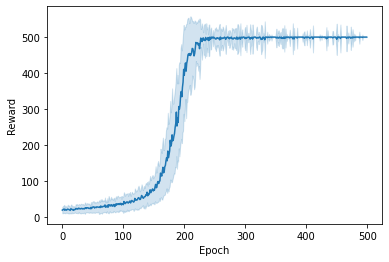

In [ ]:
# Provide your best config here and run this cell
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.99,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-3,
    'use_baseline': True,
    'value_layers': [16,8],
    'value_learning_rate': 1e-2,
}
agent = ActorCriticAgent(config)
ActorCritic_rewards2 = agent.train(n_episodes=100, n_iterations=500)

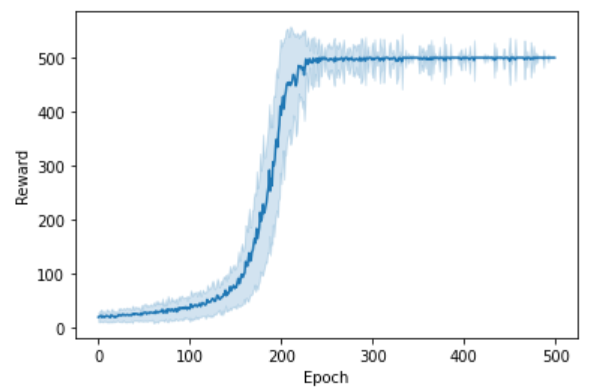

Above is the Plot for the Selected config

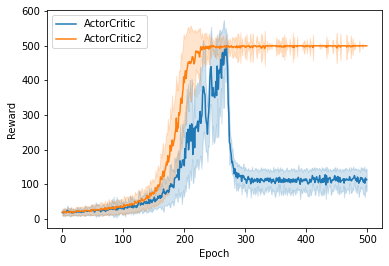

In [ ]:
# You will be graded on the output of this cell; So kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(ActorCritic_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
plt.rcParams['figure.figsize'] = [20, 20]
plt.legend(labels=['ActorCritic', 'ActorCritic2'])

####Ans 3.4
On comparing this with the implementation in 3.1 we can see that the best config is more optimal in learning as it converges to an higher reward wehre as the 3.1 failed to covnerge to a higher reward.

### Qn 3.5: Compare and plot `REINFORCEv2+B' method and 'ACTOR-CRITIC' method. [5 Marks]
Report your observations and provide explanations for the same. 

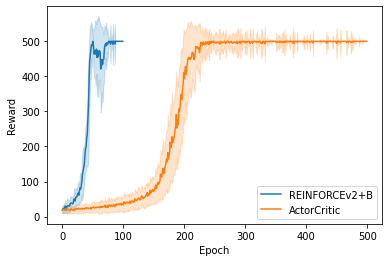

In [ ]:
# You will be graded on the output of this cell; So kindly run it

fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
plt.rcParams['figure.figsize'] = [20, 20]
plt.legend(labels=['REINFORCEv2+B', 'ActorCritic'])

From the plot we can see that the REINFORCE+Baseline converges much faster when compared to one-step actor-critic. But we can also notice that the Actor-critic method is more stable once it has converged as compared to REINFORCE+B.



### Qn 3.6: Plot all methods [2 Marks]

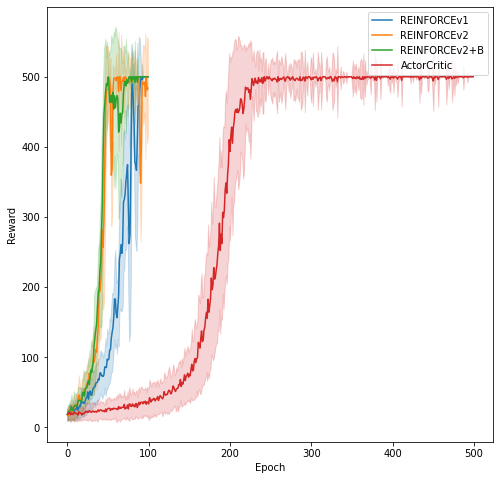

In [ ]:
# You will be graded on the output of this cell; So kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv1_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
plt.rcParams['figure.figsize'] = [8, 10]
plt.legend(labels=['REINFORCEv1', 'REINFORCEv2', 'REINFORCEv2+B', 'ActorCritic'])